In [1]:
!pip install pytorchcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 9.3 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install gdown

!gdown --id 1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX -O data.zip


/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX
To: /kaggle/working/data.zip
100%|█████████████████████████████████████████| 490k/490k [00:00<00:00, 101MB/s]


In [3]:
!unzip /kaggle/working/data.zip
!rm /kaggle/working/data.zip

Archive:  /kaggle/working/data.zip
   creating: data/
   creating: data/deer/
 extracting: data/deer/deer13.png    
 extracting: data/deer/deer6.png     
 extracting: data/deer/deer11.png    
 extracting: data/deer/deer2.png     
 extracting: data/deer/deer10.png    
 extracting: data/deer/deer16.png    
 extracting: data/deer/deer9.png     
 extracting: data/deer/deer20.png    
 extracting: data/deer/deer15.png    
 extracting: data/deer/deer19.png    
 extracting: data/deer/deer5.png     
 extracting: data/deer/deer14.png    
 extracting: data/deer/deer4.png     
 extracting: data/deer/deer8.png     
 extracting: data/deer/deer12.png    
 extracting: data/deer/deer1.png     
 extracting: data/deer/deer7.png     
 extracting: data/deer/deer17.png    
 extracting: data/deer/deer18.png    
 extracting: data/deer/deer3.png     
   creating: data/horse/
 extracting: data/horse/horse9.png   
 extracting: data/horse/horse1.png   
 extracting: data/horse/horse16.png  
 extracting: data/horse

In [4]:
import glob
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt

#data processing
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images


class MyDataset(Dataset):
    def __init__(self):
        self.images=[]
        self.labels=[]
        self.transforms=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(cifar_10_mean,cifar_10_std)
        ])
        for i,data_dir in enumerate(sorted(glob.glob(r"/kaggle/working/data/*"))):
            for _,im in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
                self.images.append(self.transforms(Image.open(im)))
                self.labels.append(i)
    def __getitem__(self,idx):
        return self.images[idx],self.labels[idx]
    def __len__(self):
        return len(self.images)

dataset=MyDataset()
dataloader=DataLoader(dataset,batch_size=8)


In [5]:
from pytorchcv.model_provider import get_model as ptcv_get_model

#select model
model_res56 = ptcv_get_model('resnet56_cifar10', pretrained=True).to('cuda')
model_res110 = ptcv_get_model('resnet110_cifar10', pretrained=True).to('cuda')
model_res164 = ptcv_get_model('resnet164bn_cifar10', pretrained=True).to('cuda')
model_pres56 = ptcv_get_model('preresnet56_cifar10', pretrained=True).to('cuda')  

In [6]:
import torch.nn as nn


std=torch.tensor(cifar_10_std)
#L-Infinity constraints
epsilon=torch.unsqueeze(8/(255*std).view(3,1,1),dim=0).to('cuda')#tensor([0.1553, 0.1577, 0.1561])

#Generate Adversarial images
def i_FGSM_ensemble(image,label,models,loss_fn,epsilon):
    im_ori=torch.unsqueeze(image.clone().detach(),dim=0).to('cuda')
    im=torch.unsqueeze(image.clone().detach(),dim=0).to('cuda')
    for i in range(10):
        output=0.0
        for mn in range(len(models)):
            im.requires_grad_()
            output+=models[mn](im)
        output/=len(models)
        loss=loss_fn(output,torch.tensor([label]).to('cuda'))
        loss.backward()
        grad=im.grad
        im=(im+0.1*(grad.sign())).clone().detach().to('cuda')
        im=torch.clamp(im,min=im_ori-epsilon,max=im_ori+epsilon)
    return im


adv_images_ex_res56=[]
adv_images_ex_res110=[]
adv_images_ex_res164=[]
adv_images_ex_pres56=[]

adv_images_res56=[]
adv_images_res110=[]
adv_images_res164=[]
adv_images_pres56=[]
loss_fn=nn.CrossEntropyLoss()        
for i,data in enumerate(dataset):
    ima,label=data
    if(i%50==0):
        print(i)
    #save adversarial images generated by I-FGSM+Ensemble
    adv_images_ex_res56.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res164,model_res110,model_pres56],loss_fn,epsilon),dim=0))
    adv_images_ex_res110.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res164,model_res56,model_pres56],loss_fn,epsilon),dim=0))
    adv_images_ex_res164.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res56,model_res110,model_pres56],loss_fn,epsilon),dim=0))
    adv_images_ex_pres56.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res164,model_res110,model_res56],loss_fn,epsilon),dim=0))
    #save adversarial images generated only by I-FGSM
    adv_images_res56.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res56],loss_fn,epsilon),dim=0))
    adv_images_res110.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res110],loss_fn,epsilon),dim=0))
    adv_images_res164.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_res164],loss_fn,epsilon),dim=0))
    adv_images_pres56.append(torch.squeeze(i_FGSM_ensemble(ima,label,[model_pres56],loss_fn,epsilon),dim=0))

0
50
100
150


In [8]:
#adversarial images processing
class adv_dataset(Dataset):
    def __init__(self,images):
        self.images=images
        self.labels=[]
        for i in range(10):
            self.labels+=([i]*20)
    def __getitem__(self,idx):
        return self.images[idx],self.labels[idx]
    def __len__(self):
        return len(self.images)

adv_images_ex_res56_dataset=adv_dataset(adv_images_ex_res56)
adv_images_ex_res110_dataset=adv_dataset(adv_images_ex_res110)
adv_images_ex_res164_dataset=adv_dataset(adv_images_ex_res164)
adv_images_ex_pres56_dataset=adv_dataset(adv_images_ex_pres56)

adv_images_ex_res56_dataloader=DataLoader(adv_images_ex_res56_dataset,batch_size=20)
adv_images_ex_res110_dataloader=DataLoader(adv_images_ex_res110_dataset,batch_size=20)
adv_images_ex_res164_dataloader=DataLoader(adv_images_ex_res164_dataset,batch_size=20)
adv_images_ex_pres56_dataloader=DataLoader(adv_images_ex_pres56_dataset,batch_size=20)

adv_images_res56_dataset=adv_dataset(adv_images_res56)
adv_images_res110_dataset=adv_dataset(adv_images_res110)
adv_images_res164_dataset=adv_dataset(adv_images_res164)
adv_images_pres56_dataset=adv_dataset(adv_images_pres56)

adv_images_res56_dataloader=DataLoader(adv_images_res56_dataset,batch_size=20)
adv_images_res110_dataloader=DataLoader(adv_images_res110_dataset,batch_size=20)
adv_images_res164_dataloader=DataLoader(adv_images_res164_dataset,batch_size=20)
adv_images_pres56_dataloader=DataLoader(adv_images_pres56_dataset,batch_size=20)

models=[model_res56,model_res110,model_res164,model_pres56]
adv_ex_dataloaders=[adv_images_ex_res56_dataloader,adv_images_ex_res110_dataloader,adv_images_ex_res164_dataloader,adv_images_ex_pres56_dataloader]
adv_dataloaders=[adv_images_res56_dataloader,adv_images_res110_dataloader,adv_images_res164_dataloader,adv_images_pres56_dataloader]

#compute model's benign_acc
def acc(model,dataloader):
    acc=0.0
    for i,data in enumerate(dataloader):
        ims,labels=data
        ims=ims.to('cuda')
        labels=labels.to('cuda')
        output=model(ims)
        acc+=(output.argmax(dim=1)==labels).sum().item()
    acc/=200
    return acc

print('benign:', acc(models[0],dataloader),acc(models[1],dataloader),acc(models[2],dataloader),acc(models[3],dataloader))

#compute model's acc on I-FGSM adversrial images
def adv_acc(models,dataloaders):
    print('adv_acc')
    for i in range(len(dataloaders)):
        for j in range(len(models)):
            print('model',j,'dataloader',i,acc(models[j],dataloaders[i]))
        
adv_acc(models,adv_dataloaders)

#compute model's acc on I-FGSM+Ensemble adversarial images
def ensemble_adv_acc(models,dataloaders):
    print('ensemble_adv_acc')
    for i in range(len(dataloaders)):
        for j in range(len(models)):
            print('model',j,'ex_dataloader',i,acc(models[j],dataloaders[i]))

ensemble_adv_acc(models,adv_ex_dataloaders)

benign: 0.455 0.54 0.465 0.4
adv_acc
model 0 dataloader 0 0.095
model 1 dataloader 0 0.27
model 2 dataloader 0 0.23
model 3 dataloader 0 0.28
model 0 dataloader 1 0.26
model 1 dataloader 1 0.15
model 2 dataloader 1 0.255
model 3 dataloader 1 0.245
model 0 dataloader 2 0.29
model 1 dataloader 2 0.345
model 2 dataloader 2 0.135
model 3 dataloader 2 0.265
model 0 dataloader 3 0.24
model 1 dataloader 3 0.3
model 2 dataloader 3 0.25
model 3 dataloader 3 0.15
ensemble_adv_acc
model 0 ex_dataloader 0 0.195
model 1 ex_dataloader 0 0.115
model 2 ex_dataloader 0 0.125
model 3 ex_dataloader 0 0.145
model 0 ex_dataloader 1 0.1
model 1 ex_dataloader 1 0.22
model 2 ex_dataloader 1 0.105
model 3 ex_dataloader 1 0.185
model 0 ex_dataloader 2 0.12
model 1 ex_dataloader 2 0.085
model 2 ex_dataloader 2 0.215
model 3 ex_dataloader 2 0.185
model 0 ex_dataloader 3 0.105
model 1 ex_dataloader 3 0.1
model 2 ex_dataloader 3 0.12
model 3 ex_dataloader 3 0.18


ValueError: num must be 1 <= num <= 8, not 9

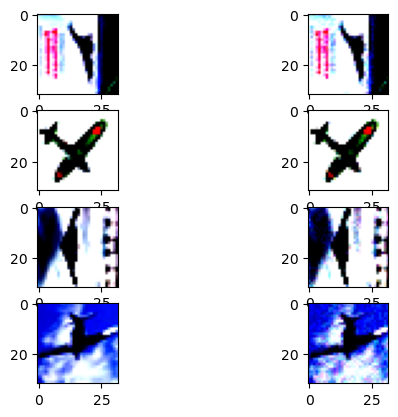

In [24]:
c=1
for i,data in enumerate(dataset):
    if i>4:
        break
    im,label=data
    plt.subplot(4,2,c)
    c+=1
    plt.imshow(im.clone().detach().permute(2,1,0))
    plt.subplot(4,2,c)
    c+=1
    plt.imshow(adv_images_ex_res56[i].permute(2,1,0).cpu())
plt.show() 